# Assignment 3: Autoregressive Moving Average Models

Tasks associated with this assignment are:
1. Load your dataset that you've been using in previous notebooks
2. Split your dataset into a training and test dataset
3. Fit the parameters of the following models to your training dataset:
    * AR(2)
    * ARMA(2,2)
4. Using the test portion of the dataset, compare the observations, AR(2), and ARMA(2,2) predictions for the following lead times:
    * 1 time period ahead
    * 3 time periods ahead
    * 5 time periods ahead
5. Characterize on the accuracy of the forecasts for each lead time and model
6. Comment on and contrast modeling approaches

### 1. Load in Arrowrock Reservoir Elevation dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as sm
from pandas.core import datetools

# Load the Arrowrock Reservoir Elevation dataset
df = pd.read_csv('ArrowrockReservoirElevation.csv', names=['Elevation','Y','M','D'], skiprows=1) #read in csv with Elevation data
df['SerDates'] = pd.to_datetime(df.Y*10000+df.M*100+df.D,format='%Y%m%d') #Define the datetime format

# Create a Water Year column for our pandas data frame. This is a pretty 
# simple thing to do, but may not be necessary if you're not dealing with
# discharge data. Here's how it goes:
# 1. Create an empty array that is full of zeros and equal in length to 
#    the number of days in the record
WY = np.zeros(len(df['Y'].index)) 
# 2. For those records where the month is less than 10, their associated 
#    year is the correct water year
WY[df['M'].values < 10] = df['Y'].values[df['M'].values < 10] 
# 3. For those records where the month is greater than or equal to 10, 
#    the correct water year is one more than the current calendar year
WY[df['M'].values >= 10] = df['Y'].values[df['M'].values >= 10] + 1
# 4. Save the water year array as a column in the pandas data frame, as an
#    integer
df['WY'] = WY.astype(int)

# Print the first and last 10 records just to make sure we loaded the data okay
qrows = np.concatenate([np.arange(0,10,1),np.arange(-11,-1,1)])
df.iloc[qrows,:]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  """


,Elevation,Y,M,D,SerDates,WY
0,3130.27,2006,10,1,2006-10-01,2007
1,3131.10,2006,10,2,2006-10-02,2007
2,3131.94,2006,10,3,2006-10-03,2007
3,3132.78,2006,10,4,2006-10-04,2007
4,3133.68,2006,10,5,2006-10-05,2007
5,3134.54,2006,10,6,2006-10-06,2007
6,3135.41,2006,10,7,2006-10-07,2007
7,3136.32,2006,10,8,2006-10-08,2007
8,3137.17,2006,10,9,2006-10-09,2007
9,3138.02,2006,10,10,2006-10-10,2007


### 2. Split dataset into a training and test dataset

In [2]:
# Divide data in to a training dataset, all non 2015 years, and a test dataset, all 2015 data
df_train = df[df.WY != 2015]
df_test  = df[df.WY == 2015]

### 3. Fit the parameters of the following models to your training dataset:
* AR(2)
* ARMA(2,2)

In [3]:
# Fit parameters for the AR(2) model
Et = pd.Series(df_train['Elevation'].values,df_train['SerDates'].values)
E_AR2_model = sm.AR(Et).fit(2)
print(E_AR2_model.params)

const    2.858975
L1.y     1.943585
L2.y    -0.944485
dtype: float64


In [4]:
# Fit parameters for the ARMA(2,2) model
E_ARMA_2_2_model = sm.ARMA(Et-np.mean(Et),(2,2)).fit()
print(E_ARMA_2_2_model.params)

const     -3.585367
ar.L1.y    1.895974
ar.L2.y   -0.896867
ma.L1.y    0.414353
ma.L2.y    0.071559
dtype: float64


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### 4. Using the test portion of the dataset, compare the observations, AR(2), and ARMA(2,2) predictions for the following lead times:
* 1 time period ahead
* 3 time periods ahead
* 5 time periods ahead

#### 0 time periods ahead

In [5]:
# Using YW equations, determine the E hat value for the AR(2) and ARMA(2,2) models
noise_std =0.654

Etrain = df_train['Elevation'].values
Etrain = Etrain.reshape(Etrain.size,1)

Etest  = df_test['Elevation'].values
Etest  = Etest.reshape(Etest.size,1)

DatesTest = df_test['SerDates'].values

Ettm1 = np.concatenate([Etrain[-2:-1],Etest[0:-1]])
Ettm1 = Ettm1.reshape(Ettm1.size,1)

Ettm2 = np.concatenate([Etrain[-3:-1],Etest[0:-2]])
Ettm2 = Ettm2.reshape(Ettm2.size,1)

etatm1 = np.random.normal(0.0,noise_std,(len(Ettm1),1))
etatm2 = np.concatenate([np.random.normal(0.0,noise_std,(2,1)),etatm1[0:-2]])

AR2_phi1 = E_AR2_model.params[1]
AR2_phi2 = E_AR2_model.params[2]

# AR(2) 0 Time Periods Ahead

EhatAR2 = AR2_phi1*Ettm1 + AR2_phi2*Ettm2

ARMA22_mu     = E_ARMA_2_2_model.params[0]
ARMA22_phi1   = E_ARMA_2_2_model.params[1]
ARMA22_phi2   = E_ARMA_2_2_model.params[2]
ARMA22_theta1 = E_ARMA_2_2_model.params[3]
ARMA22_theta2 = E_ARMA_2_2_model.params[4]

# ARMA(2,2) 0 Time Periods Ahead

EhatARMA22 = ARMA22_mu + ARMA22_phi1*Ettm1 + ARMA22_phi2*Ettm2 - ARMA22_theta1*etatm1 - ARMA22_theta2*etatm2


#### 1-5 Time Periods Ahead

In [6]:
# AR(2) 1 Time Periods Ahead

EhatAR2_t1 = AR2_phi1*EhatAR2 + AR2_phi2*Ettm1

# AR(2) 2 Time Periods Ahead

EhatAR2_t2 = AR2_phi1*EhatAR2_t1 + AR2_phi2*EhatAR2

# AR(2) 3 Time Periods Ahead

EhatAR2_t3 = AR2_phi1*EhatAR2_t2 + AR2_phi2*EhatAR2_t1

# AR(2) 4 Time Periods Ahead

EhatAR2_t4 = AR2_phi1*EhatAR2_t3 + AR2_phi2*EhatAR2_t2

# AR(2) 5 Time Periods Ahead

EhatAR2_t5 = AR2_phi1*EhatAR2_t4 + AR2_phi2*EhatAR2_t3


In [7]:
# ARMA(2,2) 0 Time Periods Ahead

EhatARMA22_t1 = ARMA22_mu + ARMA22_phi1*Ettm1 + ARMA22_phi2*Ettm2 - ARMA22_theta1*etatm1 - ARMA22_theta2*etatm2

# ARMA(2,2) 0 Time Periods Ahead

EhatARMA22_t2 = ARMA22_mu + ARMA22_phi1*EhatARMA22_t1 + ARMA22_phi2*Ettm1 - ARMA22_theta1*etatm1 - ARMA22_theta2*etatm2

# ARMA(2,2) 0 Time Periods Ahead

EhatARMA22_t3 = ARMA22_mu + ARMA22_phi1*EhatARMA22_t2 + ARMA22_phi2*EhatARMA22_t1 - ARMA22_theta1*noise_std - ARMA22_theta2*etatm1

# ARMA(2,2) 0 Time Periods Ahead

EhatARMA22_t4 = ARMA22_mu + ARMA22_phi1*EhatARMA22_t3 + ARMA22_phi2*EhatARMA22_t2 - ARMA22_theta1*noise_std - ARMA22_theta2*noise_std

# ARMA(2,2) 0 Time Periods Ahead

EhatARMA22_t5 = ARMA22_mu + ARMA22_phi1*EhatARMA22_t4 + ARMA22_phi2*EhatARMA22_t3 - ARMA22_theta1*noise_std - ARMA22_theta2*noise_std



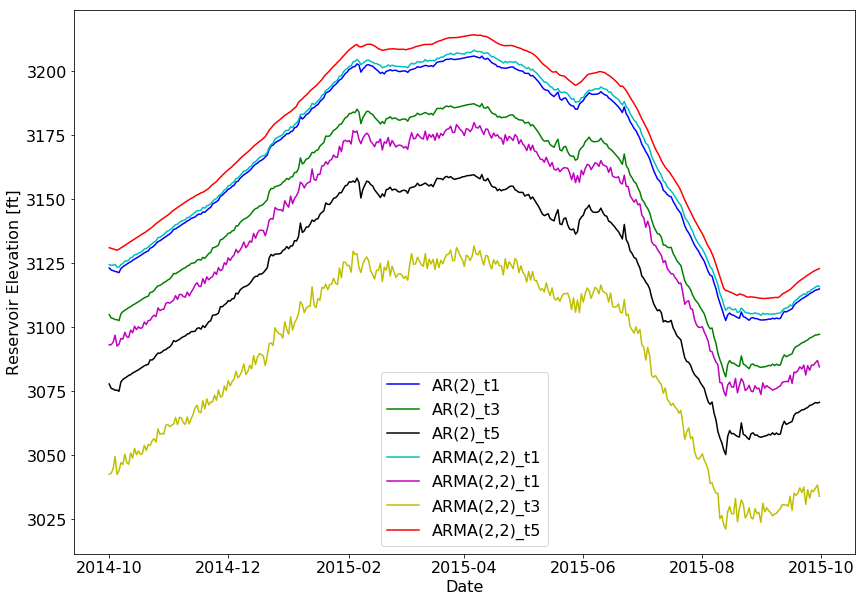

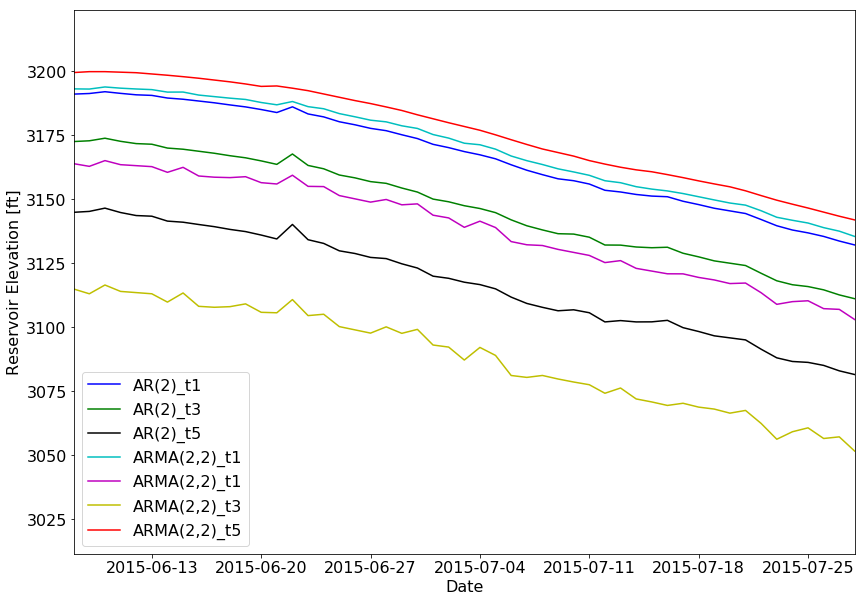

In [8]:
# Plot the models on one graph
plt.figure(figsize=(14,10))

plt.plot(DatesTest,EhatAR2_t1,'b-')
plt.plot(DatesTest,EhatAR2_t3,'g-')
plt.plot(DatesTest,EhatAR2_t5,'k-')
plt.plot(DatesTest,EhatARMA22_t1,'c-')
plt.plot(DatesTest,EhatARMA22_t3,'m-')
plt.plot(DatesTest,EhatARMA22_t5,'y-')
plt.plot(DatesTest,Etest,'r-')
plt.ylabel('Reservoir Elevation [ft]',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('AR(2)_t1','AR(2)_t3','AR(2)_t5','ARMA(2,2)_t1','ARMA(2,2)_t1','ARMA(2,2)_t3','ARMA(2,2)_t5','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

plt.figure(figsize=(14,10))
plt.plot(DatesTest,EhatAR2_t1,'b-')
plt.plot(DatesTest,EhatAR2_t3,'g-')
plt.plot(DatesTest,EhatAR2_t5,'k-')
plt.plot(DatesTest,EhatARMA22_t1,'c-')
plt.plot(DatesTest,EhatARMA22_t3,'m-')
plt.plot(DatesTest,EhatARMA22_t5,'y-')
plt.plot(DatesTest,Etest,'r-')
plt.xlim([DatesTest[250],DatesTest[300]])
plt.ylabel('Reservoir Elevation [ft]',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('AR(2)_t1','AR(2)_t3','AR(2)_t5','ARMA(2,2)_t1','ARMA(2,2)_t1','ARMA(2,2)_t3','ARMA(2,2)_t5','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

#### Error Estimations

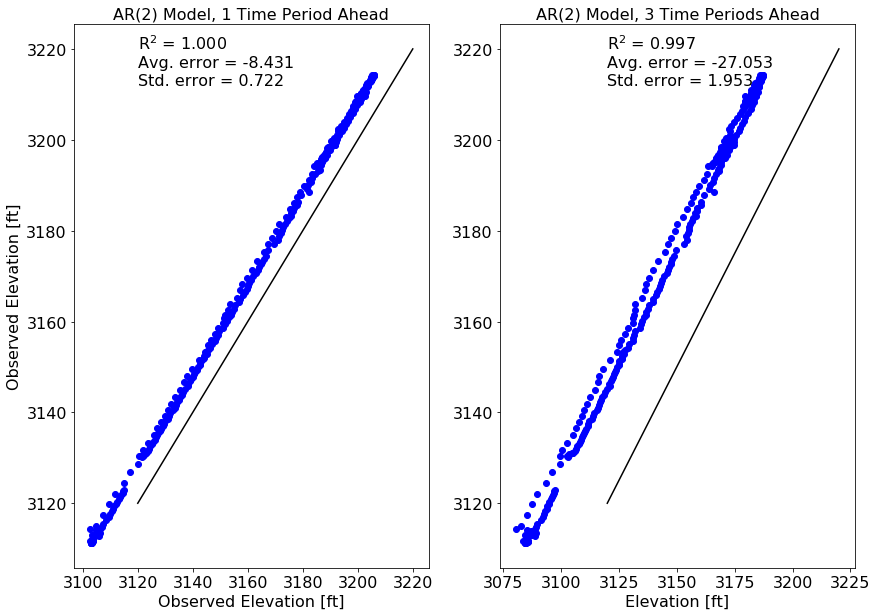

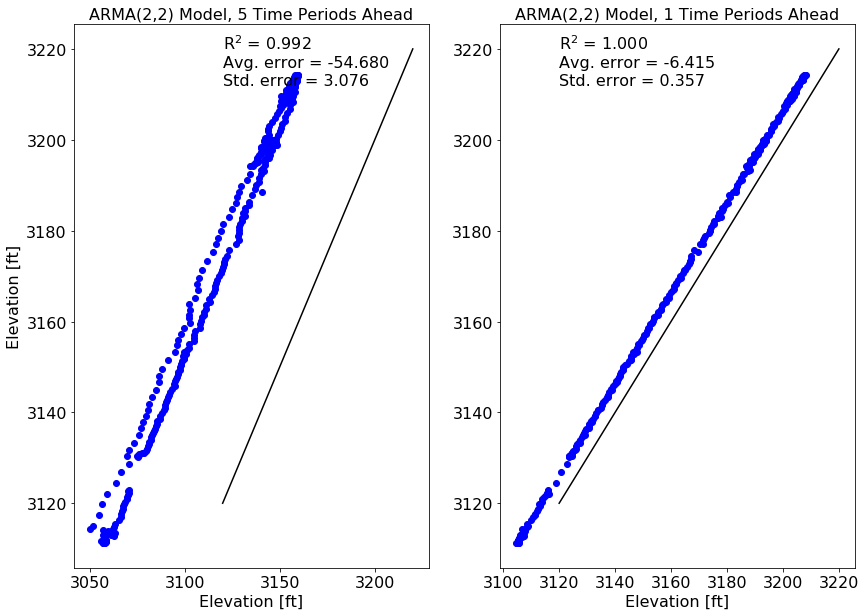

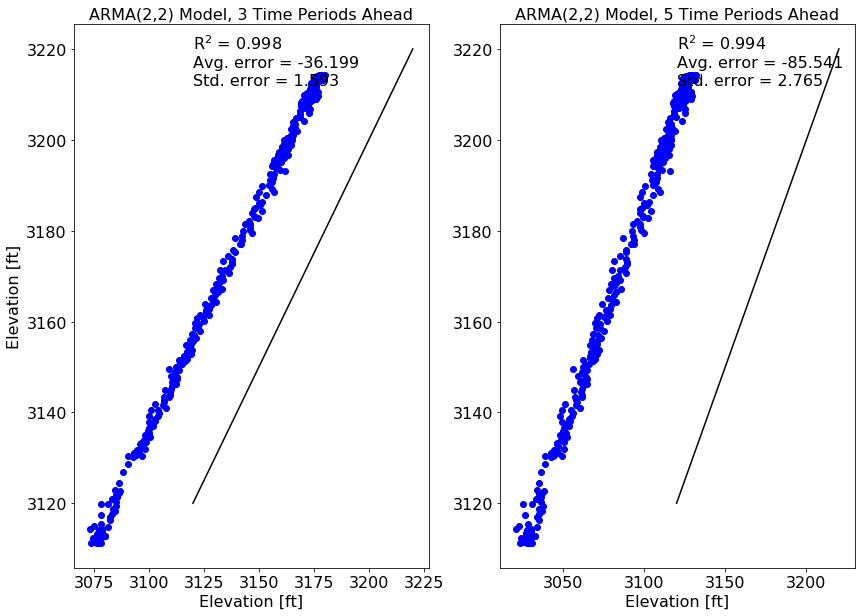

In [9]:
# Compute the R^2 values for each prediction 
R2AR2_t1  = np.corrcoef(EhatAR2_t1.T,Etest.T)**2
R2AR2_t3  = np.corrcoef(EhatAR2_t3.T,Etest.T)**2
R2AR2_t5  = np.corrcoef(EhatAR2_t5.T,Etest.T)**2
R2ARMA22_t1  = np.corrcoef(EhatARMA22_t1.T,Etest.T)**2
R2ARMA22_t3  = np.corrcoef(EhatARMA22_t3.T,Etest.T)**2
R2ARMA22_t5  = np.corrcoef(EhatARMA22_t5.T,Etest.T)**2
muAR2_t1  = np.mean(EhatAR2_t1-Etest)
muAR2_t3  = np.mean(EhatAR2_t3-Etest)
muAR2_t5  = np.mean(EhatAR2_t5-Etest)
stdAR2_t1 = np.std(EhatAR2_t1-Etest)
stdAR2_t3 = np.std(EhatAR2_t3-Etest)
stdAR2_t5 = np.std(EhatAR2_t5-Etest)
muARMA22_t1  = np.mean(EhatARMA22_t1-Etest)
muARMA22_t3  = np.mean(EhatARMA22_t3-Etest)
muARMA22_t5  = np.mean(EhatARMA22_t5-Etest)
stdARMA22_t1 = np.std(EhatARMA22_t1-Etest)
stdARMA22_t3 = np.std(EhatARMA22_t3-Etest)
stdARMA22_t5 = np.std(EhatARMA22_t5-Etest)

# Plot the ARMA(1,1) and ARMA(2,2) model results 
plt.figure(figsize=(14,10))
plt.subplot(121)
plt.plot(EhatAR2_t1,Etest,'bo')
plt.plot([3120,3220], [3120,3220], 'k-')
plt.title('AR(2) Model, 1 Time Period Ahead',fontsize=16)
plt.ylabel('Observed Elevation [ft]',fontsize=16)
plt.xlabel('Observed Elevation [ft]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2AR2_t1[0,1], xy=(3120,3220), fontsize=16)
ax.annotate('Avg. error = %.3f'%muAR2_t1, xy=(3120,3216), fontsize=16)
ax.annotate('Std. error = %.3f'%stdAR2_t1, xy=(3120,3212), fontsize=16)

plt.subplot(122)
plt.plot(EhatAR2_t3,Etest,'bo')
plt.plot([3120,3220], [3120,3220], 'k-')
plt.title('AR(2) Model, 3 Time Periods Ahead',fontsize=16)
plt.xlabel('Elevation [ft]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2AR2_t3[0,1], xy=(3120,3220), fontsize=16)
ax.annotate('Avg. error = %.3f'%muAR2_t3, xy=(3120,3216), fontsize=16)
ax.annotate('Std. error = %.3f'%stdAR2_t3, xy=(3120,3212), fontsize=16)

plt.figure(figsize=(14,10))
plt.subplot(121)
plt.plot(EhatAR2_t5,Etest,'bo')
plt.plot([3120,3220], [3120,3220], 'k-')
plt.title('ARMA(2,2) Model, 5 Time Periods Ahead',fontsize=16)
plt.ylabel('Elevation [ft]',fontsize=16)
plt.xlabel('Elevation [ft]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2AR2_t5[0,1], xy=(3120,3220), fontsize=16)
ax.annotate('Avg. error = %.3f'%muAR2_t5, xy=(3120,3216), fontsize=16)
ax.annotate('Std. error = %.3f'%stdAR2_t5, xy=(3120,3212), fontsize=16)

plt.subplot(122)
plt.plot(EhatARMA22_t1,Etest,'bo')
plt.plot([3120,3220], [3120,3220], 'k-')
plt.title('ARMA(2,2) Model, 1 Time Periods Ahead',fontsize=16)
plt.xlabel('Elevation [ft]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2ARMA22_t1[0,1], xy=(3120,3220), fontsize=16)
ax.annotate('Avg. error = %.3f'%muARMA22_t1, xy=(3120,3216), fontsize=16)
ax.annotate('Std. error = %.3f'%stdARMA22_t1, xy=(3120,3212), fontsize=16)

plt.figure(figsize=(14,10))
plt.subplot(121)
plt.plot(EhatARMA22_t3,Etest,'bo')
plt.plot([3120,3220], [3120,3220], 'k-')
plt.title('ARMA(2,2) Model, 3 Time Periods Ahead',fontsize=16)
plt.ylabel('Elevation [ft]',fontsize=16)
plt.xlabel('Elevation [ft]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2ARMA22_t3[0,1], xy=(3120,3220), fontsize=16)
ax.annotate('Avg. error = %.3f'%muARMA22_t3, xy=(3120,3216), fontsize=16)
ax.annotate('Std. error = %.3f'%stdARMA22_t3, xy=(3120,3212), fontsize=16)

plt.subplot(122)
plt.plot(EhatARMA22_t5,Etest,'bo')
plt.plot([3120,3220], [3120,3220], 'k-')
plt.title('ARMA(2,2) Model, 5 Time Periods Ahead',fontsize=16)
plt.xlabel('Elevation [ft]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2ARMA22_t5[0,1], xy=(3120,3220), fontsize=16)
ax.annotate('Avg. error = %.3f'%muARMA22_t5, xy=(3120,3216), fontsize=16)
ax.annotate('Std. error = %.3f'%stdARMA22_t5, xy=(3120,3212), fontsize=16)

plt.show()

#### Contrasting Modeling Approaches

The AR(2) and ARMA(2,2) models predicted by 1 Time Period ahead were closest to the observed values. The higher the time step prediction, the farther from observed values the model became, and the more noisey the model became. Interestingly, the models all predicted lower values than the observed reservoir elevations. This is likely a function of the downward trending observations, and thus is probably an indication that the models were succeeding in accurately predicting the future reservoir elevations levels.  

The higher time-step predictions have the largest error, while the lowest time-step predicitons have the lowest error. This makes sense, as they are compared to the observed values, and will likely have higher error as the predictions progress further in the future. 